### Imports

In [135]:
import pandas as pd
import re
import itertools   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en import English
from booknlp.booknlp import BookNLP
from IPython.core.pylabtools import figsize
sns.set_theme(style="darkgrid")
figsize(20, 15)
pd.set_option('display.max_colwidth', -1)
nlp = English()
tokenizer = nlp.tokenizer


/var/folders/0t/rs4xlk9945xdd3cxy6yc9j340000gq/T/ipykernel_17017/1519760466.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Survey data and stories

In [20]:
def get_indexes(raw):
   if( not pd.isna(raw)):
      highlights = re.findall(r'\d+:', raw)
      return list(map(lambda x: int(x.replace(':', '')) - 1, highlights))

In [21]:
data = pd.read_csv('survey_responses.csv')
data = data.drop(['StartDate', 'ResponseId', 'EndDate', 'IPAddress', 'Progress', 'Duration (in seconds)', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'Q_RecaptchaScore', 'UserLanguage'], axis=1)[data['Finished'] == 'True']
data['highlight_hp_high_1'] = data['highlight_hp_high_1'].map(get_indexes)
data['highlight_hp_high_2'] = data['highlight_hp_high_2'].map(get_indexes)
data['highlight_hp_low_1'] = data['highlight_hp_low_1'].map(get_indexes)
data['highlight_hp_low_2'] = data['highlight_hp_low_2'].map(get_indexes)
data['highlight_hero_high_1'] = data['highlight_hero_high_1'].map(get_indexes)
data['highlight_hero_high_2'] = data['highlight_hero_high_2'].map(get_indexes)
data['highlight_hero_low_1'] = data['highlight_hero_low_1'].map(get_indexes)
data['highlight_hero_low_2'] = data['highlight_hero_low_2'].map(get_indexes)

In [23]:
hp_high_sentences = list(open('hp_high.txt', 'r').read().split('\n'))
hp_low_sentences = list(open('hp_low.txt', 'r').read().split('\n'))
hero_high_sentences = list(open('hero_high.txt', 'r').read().split('\n'))
hero_low_sentences = list(open('hero_low.txt', 'r').read().split('\n'))


In [118]:
all_stories = ['hp_high', 'hp_low', 'hero_high', 'hero_low']
all_sentences = [hp_high_sentences, hp_low_sentences, hero_high_sentences, hero_low_sentences]

### Utility functions

In [24]:
def group_highlights(sent, highlights):
   highlight_array = np.zeros(len(sent))
   for x in highlights:
      if(x != None):
         highlight_array[x] += 1
   return highlight_array

In [25]:
def get_highlight_text(sent, bool_array):
   return [sent[i] for i in np.where(bool_array)[0]]

In [108]:
def show_highlight_results(storyName, sentences, data):
   column_inc = f"highlight_{storyName}_1"
   column_dec = f"highlight_{storyName}_2"
   y1 = group_highlights(sentences, data[column_inc])
   y2 = group_highlights(sentences, data[column_dec])

   return (y1, y2)

In [199]:
def get_sentence(num, story):
   story_tokens = tokens[story]
   row = story_tokens[story_tokens['token_ID_within_document'] == num]['sentence_ID']
   if(len(row) > 0):
      return story_tokens[story_tokens['token_ID_within_document'] == num]['sentence_ID'].iloc[0]
   else:
      return -1

In [193]:
def get_supersense(story):
   supersense_df = pd.read_csv(f"results/{story}/{story}.supersense", delimiter='\t')
   story_list = list(itertools.repeat(story, len(supersense_df['start_token'])))
   supersense_df['sentence'] = list(map(get_sentence, supersense_df['start_token'], story_list))
   return supersense_df

In [150]:
def count_cognition_words(supersense, sent):
   cognition_counts = np.zeros(len(sent))
   for i in range(len(sent)):
      supersense_tokens = supersense[supersense['sentence'] == i]['supersense_category']
      for j in supersense_tokens:
         if(j == 'noun.cognition' or j == 'verb.cognition'):
            cognition_counts[i] += 1
   return cognition_counts

In [80]:
def get_concreteness_scores(sentence):
   tokens = tokenizer(sentence)
   score = 0
   for token in tokens:
      row = concreteness_scores[concreteness_scores['Word'] == str(token)]
      if(len(row) > 0):
         score = score + row['Conc.M'].iloc[0]
   return score / len(tokens)

### Process highlights

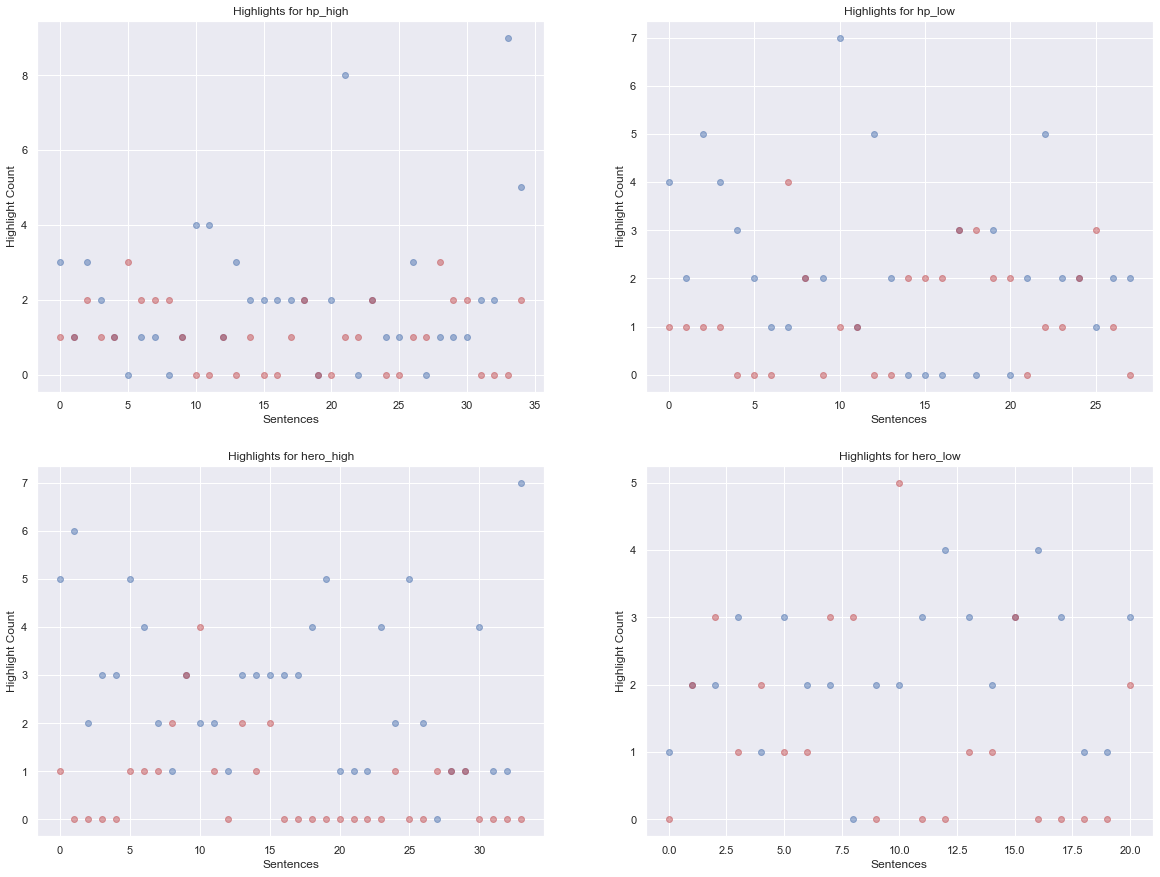

In [129]:
counts_inc = dict(zip(all_stories, np.zeros(len(all_stories))))
counts_dec = dict(zip(all_stories, np.zeros(len(all_stories))))
sentence_counts = dict(zip(all_stories, np.zeros(len(all_stories))))
sentences = dict(zip(all_stories, all_sentences))
fig, ax = plt.subplots(2, 2)
count = 0
axes = [[0, 0], [0, 1], [1, 0], [1, 1]]

for story in all_stories:
   counts_inc[story], counts_dec[story] = show_highlight_results(story, sentences[story], data) # show individual results by passing in a row: data[1:2]
   sentence_counts[story] = pd.DataFrame(sentences[story], columns=['sentence'])
   sentence_counts[story]['increase'] = counts_inc[story]
   sentence_counts[story]['decrease'] = counts_dec[story]
   # display(sentence_counts[story].head())
   # Plot the highlights
   x = np.linspace(0, len(sentences[story]) -1, len(sentences[story]))
   ax1 = axes[count][0]
   ax2 = axes[count][1]
   ax[ax1, ax2].scatter(x, counts_inc[story], alpha=.5, color='b')
   ax[ax1, ax2].scatter(x, counts_dec[story], alpha=.5, color='r')
   ax[ax1, ax2].set_xlabel("Sentences")
   ax[ax1, ax2].set_ylabel("Highlight Count")
   ax[ax1, ax2].set_title(f"Highlights for {all_stories[count]}")

   count +=1
plt.show()


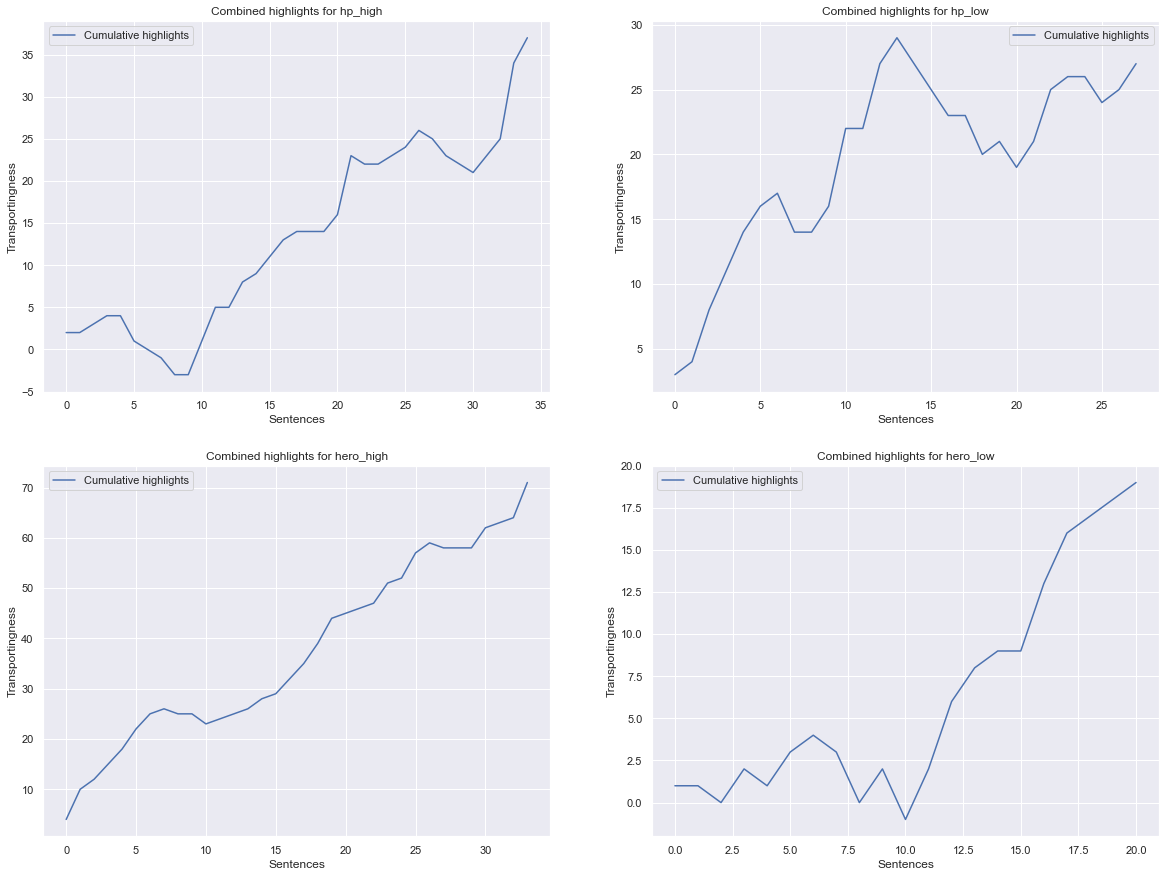

In [133]:


fig, ax = plt.subplots(2, 2)
count = 0
combined_highlights = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
   combined_highlights[story] = counts_inc[story] - counts_dec[story]

   cdf = np.cumsum(combined_highlights[story])
   # Plot the highlights
   x = np.linspace(0, len(sentences[story]) -1, len(sentences[story]))
   ax1 = axes[count][0]
   ax2 = axes[count][1]
   ax[ax1, ax2].plot(x, cdf, color='b', label="Cumulative highlights")
   ax[ax1, ax2].set_xlabel("Sentences")
   ax[ax1, ax2].set_ylabel("Transportingness")
   ax[ax1, ax2].set_title(f"Combined highlights for {all_stories[count]}")
   ax[ax1, ax2].legend()
   count +=1

plt.show()

In [40]:
questions = pd.read_csv('survey_responses.csv')[0:1]

In [41]:
scale_questions = ['emotional_affect', 'forgetting_surroundings', 'distracted', 'characters_alive', 'mental_imagery']

### BookNLP, LIWC, and Concreteness data

In [89]:
def run_booknlp(story):
	model_params={
			"pipeline":"entity,quote,supersense,event,coref", 
			"model":"big"
		}
		
	booknlp=BookNLP("en", model_params)

	# Input file to process
	input_file="hp_low.txt"

	# Output directory to store resulting files in
	output_directory="results/hp_low"

	# File within this directory will be named ${book_id}.entities, ${book_id}.tokens, etc.
	book_id="hp_low"

	booknlp.process(input_file, output_directory, book_id)

In [209]:
# for story in all_stories:
#    run_booknlp(story)

In [212]:
concreteness_scores = pd.read_csv("concreteness_scores.csv")
liwc = pd.read_csv('liwc_results.csv')

In [216]:
tokens = dict(zip(all_stories, np.zeros(len(all_stories))))
supersense = dict(zip(all_stories, np.zeros(len(all_stories))))
pairplot_df = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
   tokens[story] = pd.read_csv(f"results/{story}/{story}.tokens", delimiter='\t')
   supersense[story] = get_supersense(story)
   sentence_counts[story]['cognition'] = count_cognition_words(supersense[story], sentences[story], story)
   sentence_counts[story]['perception'] = list(liwc[liwc['Filename'] == f'{story}.txt']['Perception'])
   sentence_counts[story]['concreteness'] = list(map(get_concreteness_scores, sentences[story]))
   pairplot_df[story] = sentence_counts[story].drop('sentence', axis=1)


<img src="perception.png" width="50%" height="50%">

### Add Sentiment scores

In [ ]:
# sentiment = pd.read_csv(f"feature_results/sentiment/{story}_sent.csv")['sentiment']
# sentence_counts['sentiment'] = list(sentiment)

### Compute Correlations

In [218]:
pairplot_df['hero_high'].head()

,increase,decrease,cognition,perception,concreteness
0,5.0,1.0,0.0,5.26,1.902174
1,6.0,0.0,0.0,42.11,2.415238
2,2.0,0.0,0.0,0.00,0.911429
3,3.0,0.0,0.0,0.00,1.172000
4,3.0,0.0,0.0,0.00,0.690000


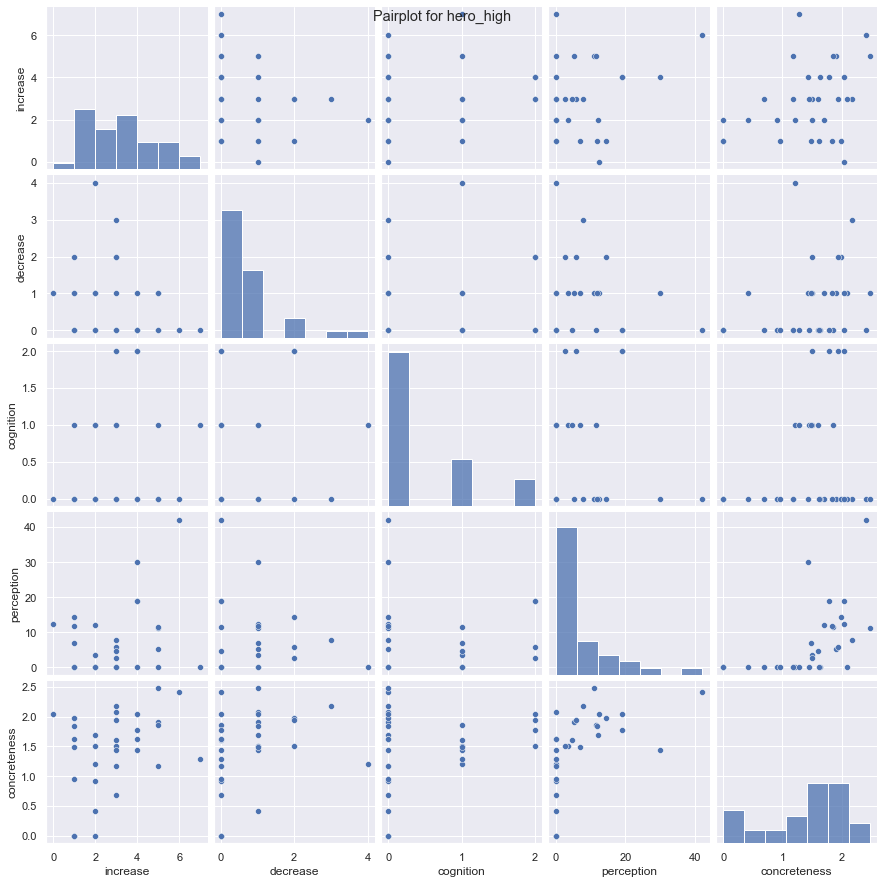

In [219]:
story_pairplot = sns.pairplot(pairplot_df['hero_high'])
story_pairplot.fig.suptitle(f"Pairplot for hero_high")
plt.show()

Correlation for hp_high


,increase,decrease,cognition,perception,concreteness
increase,1.000000,-0.255566,-0.130094,0.166053,0.544731
decrease,-0.255566,1.000000,-0.015702,0.102251,-0.015454
cognition,-0.130094,-0.015702,1.000000,-0.266861,0.115714
perception,0.166053,0.102251,-0.266861,1.000000,0.172344
concreteness,0.544731,-0.015454,0.115714,0.172344,1.000000


Correlation for hp_low


,increase,decrease,cognition,perception,concreteness
increase,1.000000,-0.354405,-0.401010,0.173430,0.105606
decrease,-0.354405,1.000000,0.137390,-0.398019,0.173963
cognition,-0.401010,0.137390,1.000000,-0.244645,-0.003719
perception,0.173430,-0.398019,-0.244645,1.000000,0.427456
concreteness,0.105606,0.173963,-0.003719,0.427456,1.000000


Correlation for hero_high


,increase,decrease,cognition,perception,concreteness
increase,1.000000,-0.139494,0.242685,0.339837,0.425900
decrease,-0.139494,1.000000,0.169768,0.042629,0.332065
cognition,0.242685,0.169768,1.000000,0.099706,0.265022
perception,0.339837,0.042629,0.099706,1.000000,0.551471
concreteness,0.425900,0.332065,0.265022,0.551471,1.000000


Correlation for hero_low


,increase,decrease,cognition,perception,concreteness
increase,1.000000,-0.223855,-0.087057,0.317234,0.420122
decrease,-0.223855,1.000000,0.446279,-0.054785,0.258413
cognition,-0.087057,0.446279,1.000000,-0.176266,0.126493
perception,0.317234,-0.054785,-0.176266,1.000000,0.350709
concreteness,0.420122,0.258413,0.126493,0.350709,1.000000


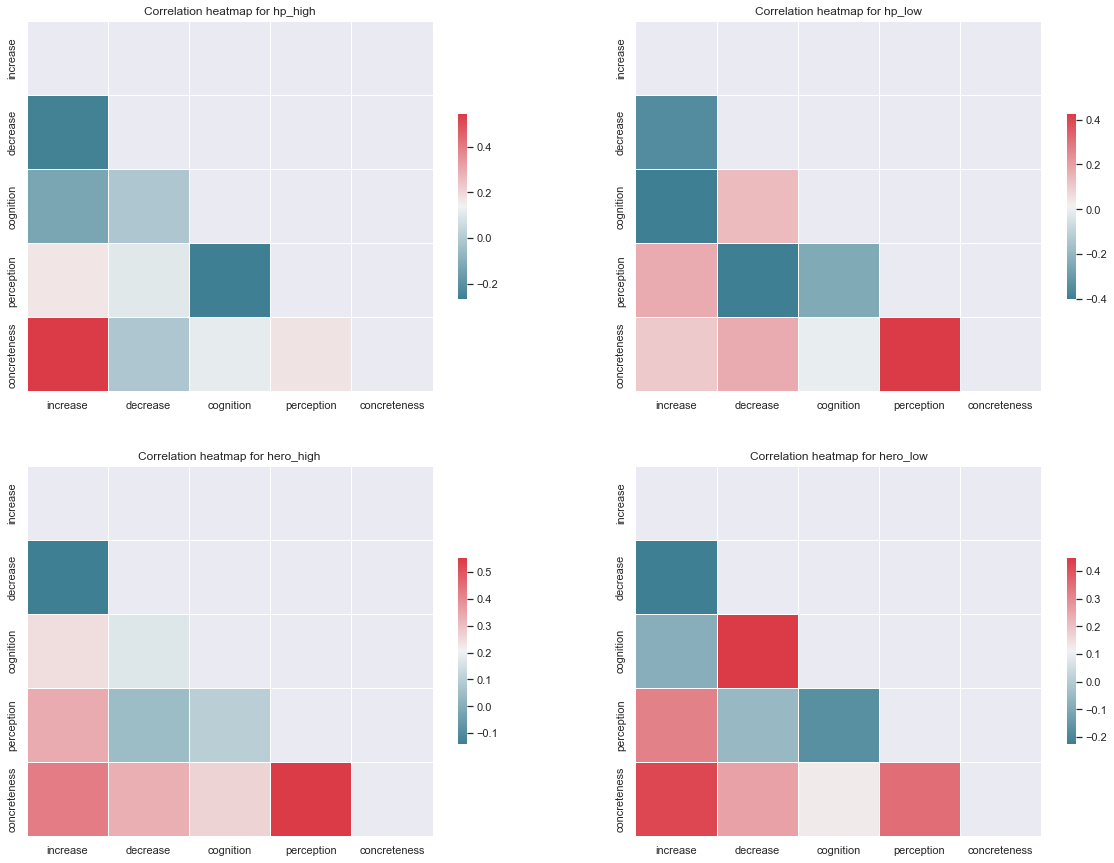

In [227]:
corr = dict(zip(all_stories, np.zeros(len(all_stories))))
f, ax = plt.subplots(2, 2)
count = 0
axes = [[0, 0], [0, 1], [1, 0], [1, 1]]

for story in all_stories:
    ax1 = axes[count][0]
    ax2 = axes[count][1]

    # Compute the correlation matrix
    corr[story] = pairplot_df[story].corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr[story], dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr[story],
        mask=mask,
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        ax=ax[ax1, ax2]
    )
    ax[ax1, ax2].set_title(f"Correlation heatmap for {story}")
    print(f"Correlation for {story}")
    display(corr[story])
    count += 1

plt.show()

